In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append('../')

In [3]:
import dembuilder as db
import numpy as np

The dembuilder compiles bathymetry files from a range of data formats and where the data has varying spatial coverage into a single DEM which is saved as a raster file

The object model consists of:
 - SamplePointReader - reads datafiles, returns a SamplePoints object
 - SamplePoints - x,y,z data read from a file, defines methods to apply samples to a Raster object
 - Raster - the actual DEM we are building


### Raster

Currently uses a rectilinear grid to compile all the bathymetry into a raster of a specified resolution with in a defined bounding box (bbox)

In [4]:
bbox=np.zeros(4)
bbox[0] = 220000 #left
bbox[1] = 7570000 #bottom
bbox[2] = 270000 #right
bbox[3] = 7620000 #top
newRaster = db.Raster(bbox=bbox, resolution=500, epsgCode=28350)

### SamplePointReader

The sample point reader reads a datafile, optionally crops a box out of the data and drops missing values. Calling SamplePointReader.load() will read the data from disk and return a Samples object.

In [5]:
sampleReader = db.SamplePointReader('Pilbara_200m_Composite_Linear.tif',cropTo=bbox)
samples = sampleReader.load()

Pilbara_200m_Composite_Linear.tif
SamplePointFormat.GeoTIFF
Source projection: +proj=utm +zone=50 +south +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs 


### SamplePoints

SamplePoints is an object with three numpy arrays for the x, y and z coordinates of the samples.

In [6]:
samples

Total samples: 62001 
 x=array([220200., 220400., 220600., ..., 269400., 269600., 269800.]) 
 y=array([7570200., 7570200., 7570200., ..., 7619800., 7619800., 7619800.]) 
 z=array([-19.55293655, -19.49410439, -19.46491051, ..., -15.97682858,
       -17.66632652, -18.85404587])

Before any loaded samples can be used to fill the raster, you must specify the type of boundary to use to limit extrapolation. The boundary types are called

In [7]:
[t for t in db.BoundaryPolygonType]

[<BoundaryPolygonType.Box: 0>,
 <BoundaryPolygonType.ConvexHull: 1>,
 <BoundaryPolygonType.ConcaveHull: 2>]

Generate a box boundary

In [8]:
samples.generateBoundary(type=db.BoundaryPolygonType.Box)

We can make a scatter plot of the samples by calling .plot()

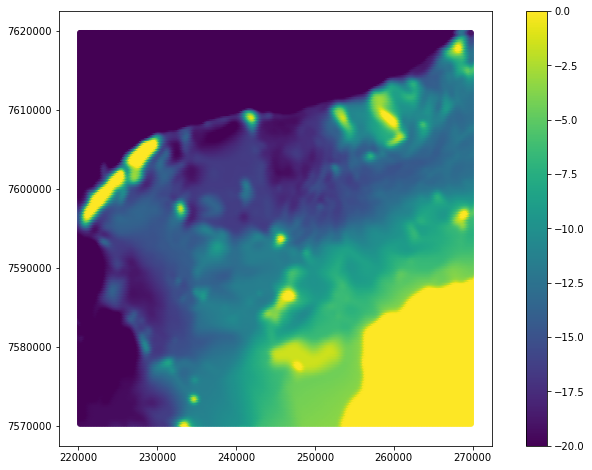

In [9]:
samples.plot()

Make another set of random samples for demonstration purposes

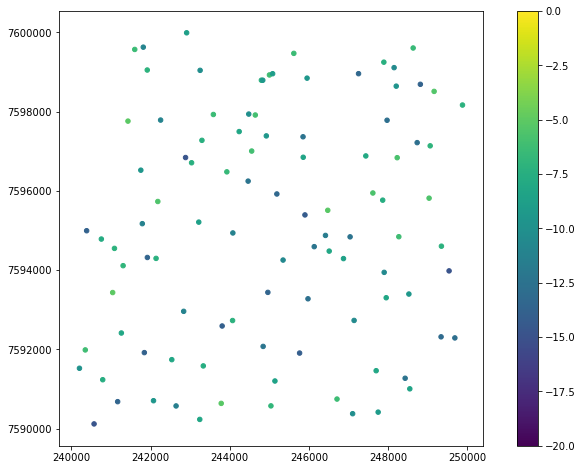

In [10]:
x = np.random.rand(100) * 10000 + 240000
y = np.random.rand(100) * 10000 + 7590000
z = np.random.rand(100) * 10 - 15 
randomSamples = db.SamplePoints(x,y,z)
randomSamples.plot()

The concave hull can take quite some time to calculate if there are many samples and you should specify a threshold distance beyond which the edges of the triangulation will be weeded. 

In [11]:
randomSamples.generateBoundary(type=db.BoundaryPolygonType.ConcaveHull,threshold=1500)

### The Raster object can be filled with samples using a variety of resampling methods

In [12]:
[t for t in db.ResampleMethods]

[<ResampleMethods.BlockAvg: 0>,
 <ResampleMethods.Linear: 1>,
 <ResampleMethods.Cubic: 2>,
 <ResampleMethods.SmoothCubic: 3>,
 <ResampleMethods.BsplineLSQ: 4>,
 <ResampleMethods.BsplineSmooth: 5>,
 <ResampleMethods.Rbf: 6>,
 <ResampleMethods.Kriging: 7>,
 <ResampleMethods.NaturalNeighbour: 8>]

If the samples are sparse compared to the raster grid resolution then the interpolation methods > 1 (Linear) should be used. Otherwise block averaging (also referred to as grid cell averaging) is likely the preferred method

Firstly we will linearly interpolate the randome samples, only inside the calculated ConcaveHull

In [13]:
randomSamples.resample(newRaster,method=db.ResampleMethods.Linear)

Using 100 SamplePoints to fill 92 raster points with in the SamplePoints boundary


Plot the result

(<Figure size 864x576 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f108acb4160>)

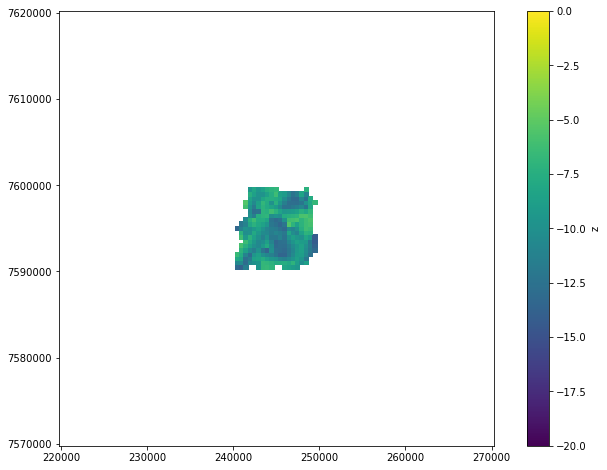

In [14]:
newRaster.plot()

In [15]:
samples.resample(newRaster,method=db.ResampleMethods.BlockAvg)

(<Figure size 864x576 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f108933ae80>)

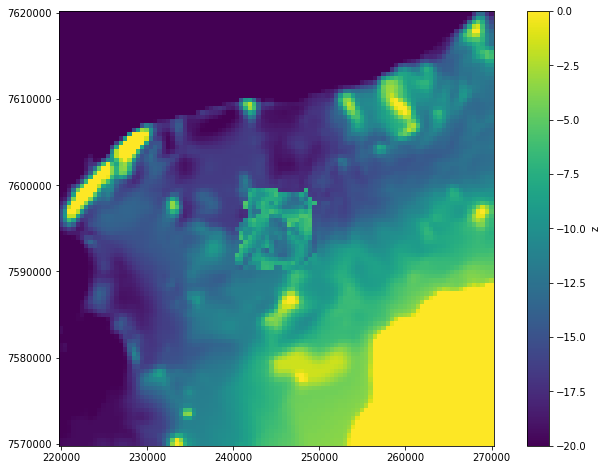

In [16]:
newRaster.plot()

### Save out the resulting raster as a GeoTIFF...

In [17]:
newRaster.saveToFile('tempRaster.tiff')

### ... or extract the samples and save as an XYZ file

In [18]:
newRaster.getSamples().saveXYZ('tempRaster.xyz')

### Saved rasters can be loaded directly too

(<Figure size 864x576 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1088eda940>)

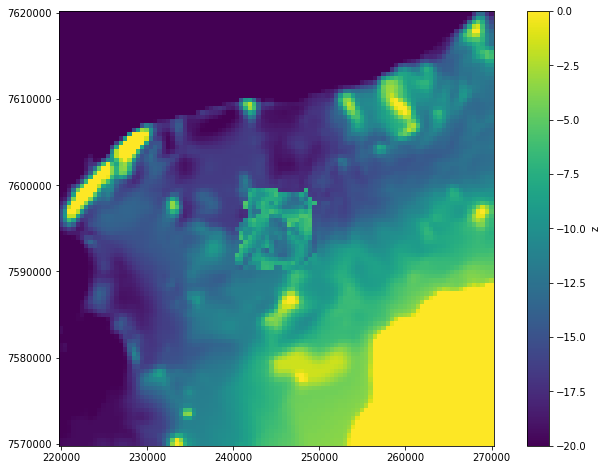

In [19]:
loadedRaster = db.Raster.loadFromFile('tempRaster.tiff')
loadedRaster.plot()